In [1]:
import pandas as pd
import numpy as np
from pybnesian import hc, CLGNetworkType, SemiparametricBNType, SemiparametricBN
#from drawdata import draw_scatter
import matplotlib.pyplot as plt
import math

from pymoo.core.problem import ElementwiseProblem

from pymoo.optimize import minimize

from bayesace.utils import *
from bayesace.algorithms.bayesace_algorithm import BayesACE
from bayesace.algorithms.face import FACE

from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [2]:
df = pd.read_csv("toy-3class.csv")
df["class"] = df["z"].astype('category')
df = df.drop("z", axis = 1 )

feature_columns = [i for i in df.columns if i != "class"]
df[feature_columns] = StandardScaler().fit_transform(df[feature_columns].values)
df = df.sample(frac=1, random_state=0).reset_index(drop=True)
df_test = df.tail(70)
df = df.head(350)

In [ ]:
df = pd.read_csv("six_gaussians.csv")
df["class"] = df["class"].astype(str).astype('category')

feature_columns = [i for i in df.columns if i != "class"]
df[feature_columns] = StandardScaler().fit_transform(df[feature_columns].values)
df = df.sample(frac=1).reset_index(drop=True)

In [3]:
from bayesace.models.utils import get_data

df = get_data(-1)
learned = hill_climbing(df, bn_type = "CLG", score = "bic")
#learned = hc(df, bn_type = CLGNetworkType(), operators = ["arcs"], score = "validated-lik")
#learned.fit(df)

'''naive = SemiparametricBN(df.columns)
feature_columns = [i for i in df.columns if i != "class"]
for i in [i for i in df.columns if i != "class"] :
    naive.add_arc("class", i)
learned_kde = hc(df, start = naive, operators = ["arcs", "node_type"], score = "validated-lik")
learned_kde.fit(df)'''





'naive = SemiparametricBN(df.columns)\nfeature_columns = [i for i in df.columns if i != "class"]\nfor i in [i for i in df.columns if i != "class"] :\n    naive.add_arc("class", i)\nlearned_kde = hc(df, start = naive, operators = ["arcs", "node_type"], score = "validated-lik")\nlearned_kde.fit(df)'

In [33]:
print(learned.logl(df).mean())

ValueError: Variable class is not categorical.

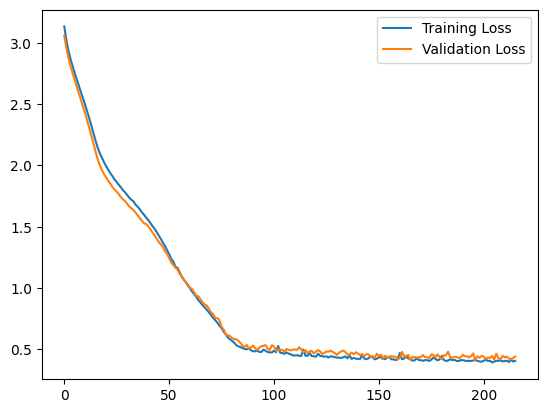

In [8]:
from bayesace.models.conditional_nvp import ConditionalNVP

nf = ConditionalNVP()
nf.train(df, batch_size=64,hidden_units=10, split_dim=1,n_flows=5, layers=2, weight_decay=1e-3, steps=1000)



In [10]:
print(nf.logl(df).mean())

-1.427946252322549


In [ ]:
df

In [ ]:
auc(df_test["class"].values,predict_class(df_test, mbnaf))

In [ ]:
brier_score(df_test["class"].values,predict_class(df_test, mbnaf))

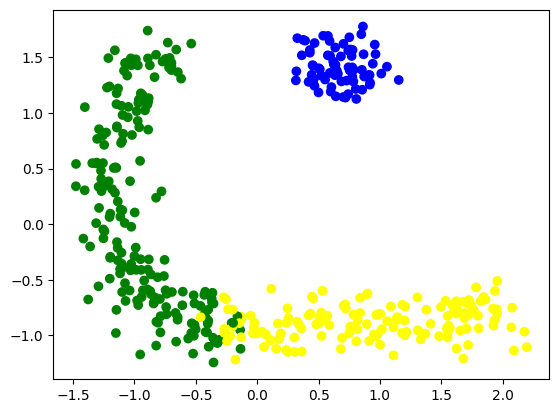

In [3]:
to_plot = df.drop("class", axis = 1)
colours = df["class"].to_numpy()
colours[colours == "a"] = "green"
colours[colours == "b"] = "yellow"
colours[colours == "c"] = "blue"
plt.scatter(to_plot["x"],to_plot["y"], color = colours)
plt.show()

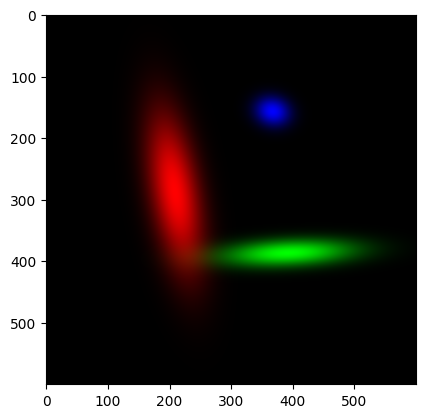

In [12]:
plt.imshow(get_probability_plot(learned, step=0.01))

In [13]:
new = predict_class(df, nf)
new["class"] = df["class"]
#new.iloc[180:220]

In [16]:
brier_score(df["class"].values,predict_class(df, nf))

0.03528753383336184

In [ ]:
learned.logl(df_test.reset_index(drop=True)).mean()

In [ ]:
instance = df.iloc[[0]]
instance["class"] = pd.Categorical(["a"], categories=learned.cpd("class").variable_values())
log_likelihood(instance,learned)

In [3]:
print(df.iloc[[0]])

          x         y class
0 -1.293227 -0.558966     a


In [9]:
n_vertex = 0
x_og = df.iloc[[0]]
times = []
res_b = None
for _ in range(1) :
    t0 = time.time()
    bayesace = BayesACE(bayesian_network=nf, features= df.columns[:-1], n_vertex=n_vertex, chunks = 10, penalty=1, pop_size=150, likelihood_threshold=np.exp(-2), accuracy_threshold= 0.95, generations=20, verbose=True)
    res = bayesace.run(x_og, target_label="b")
    times.append(time.time()-t0)
    res_b = res
print(np.mean(times),"+-",np.std(times))

# Current (parallel elementwise)
# 0 -1.293227 -0.558966     a
# 31.430654859542848 +- 2.534020054648406

# Removed list from path computation
#18.63137505054474 +- 1.6436890313822832

# Vectorized operation (no parallelization of path computation)
# 10.134185039997101 +- 2.176279641812505

C:\Users\Enrique\Universidad\Repositories\Bayes-ACE\bayesace\algorithms\bayesace_algorithm.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  initial_sample = pd.concat([initial_sample, candidate_initial])


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      150 |      1 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      300 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     3 |      450 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0118318391 |         ideal
     4 |      600 |      1 |  0.000000E+00 |  0.000000E+00 |  0.1535928564 |         ideal
     5 |      750 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     6 |      900 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     7 |     1050 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0125266775 |         ideal
     8 |     1200 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     9 |     1350 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    10 |     1500 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f

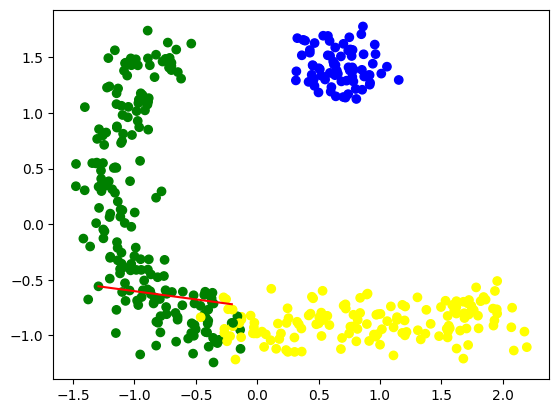

In [10]:
x_1 = x_og.drop("class",axis = 1)
df_vertex = res_b.path
to_plot = df.drop("class", axis = 1)
colours = df["class"].to_numpy()
colours[colours == "a"] = "green"
colours[colours == "b"] = "yellow"
colours[colours == "c"] = "blue"
plt.scatter(to_plot["x"],to_plot["y"], color = colours)
plt.plot(df_vertex.x,df_vertex.y,color = "red")
#plt.show()
plt.savefig("bace.png")

In [6]:
x_og = df.iloc[[0]]
face = FACE(bayesian_network=learned, features= df.columns[:-1], dataset=df.drop("class", axis = 1), graph_type = "epsilon", chunks = 10, penalty=1, distance_threshold=2, accuracy_threshold= 0.05,  likelihood_threshold=0.05, verbose = False)
res = face.run(x_og)

ValueError: Lengths must match to compare

In [ ]:
x_1 = x_og.drop("class",axis = 1)
df_vertex = res.path
to_plot = df.drop("class", axis = 1)
colours = df["class"].to_numpy()
colours[colours == "a"] = "green"
colours[colours == "b"] = "yellow"
colours[colours == "c"] = "blue"
plt.scatter(to_plot["x"],to_plot["y"], color = colours)
limit = 3
plt.plot(df_vertex.x,df_vertex.y,color = "red")
plt.xlim((-3,3))
plt.ylim((-3,3))
plt.show()
#plt.savefig("face.png")

In [ ]:
sum(abs(res.path-res_b.path))

In [ ]:
path_likelihood_length(res.path, learned) - path_likelihood_length(res_b.path, learned)